In [155]:
# !pip install --upgrade scikit-learn

#dataframe handling
import pandas as pd
#mathematics
import numpy as np

#file path stuff
import os
import pickle

#plotting
import matplotlib.pyplot as plt
import seaborn as sns

#encoding
#!pip install category_encoders
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder

#What it says on the tin
from sklearn.model_selection import train_test_split, GridSearchCV

#outlier detection
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

#imputer
from sklearn.impute import KNNImputer, SimpleImputer

#clustering checkers
from sklearn.metrics import make_scorer, silhouette_score, davies_bouldin_score, confusion_matrix, f1_score, precision_score, accuracy_score

#feature selection
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from scipy.stats import spearmanr

#balancing
#!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

#pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler

#models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

print('Modules imported')

#Read in data
disease_train = pd.read_csv('disease_train.csv')

print('Data uploaded')

#Reproducibility
np.randomseed=404
print('Random seed set')

Modules imported
Data uploaded
Random seed set


In [15]:
disease_train.head()

,id,age,gender,sick,pregnant,test_X1,test_X2,test_X3,test_X4,test_X5,...,tumor,disorder,medication_A,medication_B,mental_health,mood_stabiliser,surgery,treatment_type1,suspect,target
0,PA1001,59,male,no,no,7.8,NaN,89.0,0.85,105.0,...,no,no,no,no,no,no,no,no,no,moderate_risk
1,PA1002,48,female,no,no,1.5,2.5,101.0,0.97,104.0,...,no,no,yes,no,no,yes,no,no,no,low_risk
2,PA1003,77,male,no,no,7.3,1.2,57.0,1.28,44.0,...,no,no,no,no,no,no,no,no,no,moderate_risk
3,PA1004,42,female,no,no,1.2,2.5,106.0,0.98,108.0,...,no,no,no,no,no,no,no,no,no,low_risk
4,PA1005,38,female,no,no,0.6,1.9,95.0,NaN,NaN,...,no,no,no,no,no,no,no,no,no,low_risk


In [17]:
#Manual defined inputs

#Categorical
disease_cat = ['sick',            'pregnant',      'concern_type1',   'concern_type2',
                'enlargement',     'tumor'   ,      'disorder',        'medication_A',
                'medication_B',    'mental_health', 'mood_stabiliser', 'surgery',
                'treatment_type1', 'suspect', 'gender', 'target']

#Numerical
disease_num  = ['age', 'test_X1', 'test_X2', 'test_X3', 'test_X4', 'test_X5']


#Two sets of selected for features from data analysis
dinput = [
         'test_X1',       'test_X5',  'test_X3', 'test_X2',      'test_X4',
         'concern_type2', 'suspect',  'age',     'medication_A', 'medication_B',
         'gender',
        ]

dinput_strict = [                 
                'test_X1', 'test_X5', 'test_X3', 'test_X2', 'test_X4',
               ]

doutput = ['target']

dinput = [
         'test_X1',       'test_X5',  'test_X3', 'test_X2',      'test_X4',
         'concern_type2', 'suspect',  'age',     'medication_A', 'medication_B',
         'G_empty', 'G_female', 'G_male',
        ]

In [133]:
#I used dataframe when any dataset can be used the X_ or Y_ prefix denotes input or out put 
#occaisonally specific inputs like X_train

# Define functions for preprocessing steps
def clean_data(data_frame):
    
    #Remove ages over 100 and columns 'test_X6' & 'id'
    data_frame = data_frame[data_frame['age'] <= 100]
    data_frame = data_frame.drop(columns=['test_X6','id'])
    #Curate gender information
    data_frame['gender'] = data_frame['gender'].fillna('empty')
    #Re-index
    data_frame.reset_index(drop=True, inplace=True)
    
    return data_frame

def train_test_val_split_general(data_frame):
    #Fill null values with a place holder
    data_frame = data_frame.fillna(-999)
    #Split into 80% temp and 20% test
    X_temp, X_test, Y_temp, Y_test = train_test_split(
        data_frame[dinput], data_frame[doutput], test_size=0.2, random_state=404, stratify=data_frame[doutput]
        #data_frame[dinput_strict], data_frame[doutput], test_size=0.2, random_state=404, stratify=data_frame[doutput]
    )
    #Split into 60% train, 20% validation and 20% test

    #The train validation split (0.25 since this will make validation and test the same size)
    X_train, X_val, Y_train, Y_val = train_test_split(
        X_temp, Y_temp, test_size=0.25, random_state=404, stratify=Y_temp
                                                     )

    #Replace place holder values with null
    X_test  = X_test.replace(-999, np.nan)
    X_train = X_train.replace(-999, np.nan)
    X_val   = X_val.replace(-999, np.nan)
     
    #  print(X_train.columns)

    return X_train, X_val, X_test, Y_train, Y_val, Y_test

def train_test_only_split(data_frame):
    #Fill null values with a place holder
    data_frame = data_frame.fillna(-999)
    
    #Split into 80% temp and 20% test
    X_train, X_test, Y_train, Y_test = train_test_split(
        data_frame[dinput], data_frame[doutput], test_size=0.2, random_state=404, stratify=data_frame[doutput]
                                                     )
        
    #Replace place holder values with null
    X_test  = X_test.replace(-999, np.nan)
    X_train = X_train.replace(-999, np.nan)
    
    #print(X_train.columns)
    
    return X_train, X_test, Y_train, Y_test

def null_remove(data_frame):
    
    #Remove null values
    data_frame = data_frame.dropna()
    #Re-index
    data_frame.reset_index(drop=True, inplace=True)
    
    return data_frame

def null_impute(X_data_frame, X_train):

    #Choose imputation strategy
    imputer = SimpleImputer(strategy='median')
    #Fit imputation to data (should only be training data)
    imputer.fit(X_train[dinput_strict])
    #Transform the dataframe according to fitted data
    imputed_data = imputer.transform(X_data_frame[dinput_strict])
    #Replace the values in the dataframe with the new data
    X_data_frame[dinput_strict] = imputed_data
    
    return X_data_frame

def null_impute_knn(X_data_frame, X_train):
    
    #Choose imputation stratergy
    imputer = KNNImputer()
    #Fit imputation to data (should only be training data)
    imputer.fit(X_train[dinput_strict])
    #Transform the dataframe according to fitted data
    imputed_data = imputer.transform(X_data_frame[dinput_strict])
    #Replace the values in the dataframe with the new data
    X_data_frame[dinput_strict] = imputed_data
    
    return X_data_frame


def encode(dataframe):   
    
    #------------OneHot for gender
    enc = OneHotEncoder(handle_unknown='ignore')
    #Passing gender columns
    enc_gender = pd.DataFrame(enc.fit_transform(dataframe[['gender']]).toarray())
    #Defining new columns
    enc_gender.columns = ['G_empty', 'G_female', 'G_male']
    #Reset index for security
    dataframe.reset_index(drop=True, inplace=True)
    enc_gender.reset_index(drop=True, inplace=True)
    #Combine the encoded data and original data
    dataframe= pd.concat([dataframe, enc_gender], axis=1)
    #Remove the original gender column
    dataframe = dataframe.drop('gender', axis=1)
    #------------
    
    #------------Booleans encoding
    boolean_inputs = ['concern_type2','suspect','medication_A','medication_B']
    #Set-up the ordinal encoder, binary encoding could be used but tens to conflict with skilearn modules
    enc = ce.OrdinalEncoder(cols=boolean_inputs, handle_missing='return_nan',return_df= True)
    #Pass the dataframe
    dataframe=enc.fit_transform(dataframe)
    #------------
    
    #------------Target encoding
    #Whilst ski-learn can usually handle target variables as strings we won't risk error and we'll label encode them
    #Manually set levels (could use ordinal encoding but since it's only a 3 and I want custom levels maanually set them),
    levels = {'low_risk':1, 'moderate_risk':2, 'high_risk':3 }
    dataframe['target'].replace(levels, inplace=True)
    #Pass output data
    #------------
    
    return dataframe
       
def standardisation(X_dataframe, X_train):
    boolean_inputs = ['concern_type2','suspect','medication_A','medication_B']
    X_dataframe[boolean_inputs] = X_dataframe[boolean_inputs].copy() - 1 #Move them between [0,1]
    #Picking a scaler this one just uses min/max to scale values between [0,1]
    scaler = MinMaxScaler()
    #Fit to the training data
    scaler = scaler.fit(X_train[disease_num])
    #Transform the dataframe
    X_dataframe[disease_num] = scaler.transform(X_dataframe[disease_num])

    return X_dataframe
    
def balancer(X_train, Y_train):
    #re-index
    X_train.reset_index(drop=True, inplace=True)
    Y_train.reset_index(drop=True, inplace=True)
    
    #You have to do this so when downsampling you don't remove only rows from Y_train
    data_to_balance = pd.concat([X_train, Y_train], axis=1)
    
#     print(data_to_balance.isnull().sum())

    #Split out the target classes
    low_risk = data_to_balance[data_to_balance['target'] == 1.0]
    moderate_risk = data_to_balance[data_to_balance['target'] == 2.0]
    high_risk = data_to_balance[data_to_balance['target'] == 3.0]
    
    #Downsample the majority class
    low_risk_downsampled = resample(low_risk, replace=False, n_samples=1000, random_state=404)
    #Rejoin the classes
    data_to_balance = pd.concat([low_risk_downsampled, moderate_risk, high_risk])
    
    #Seperate out the data again into X_train & Y_train
    X_train = data_to_balance.drop(columns=['target'])
    Y_train = data_to_balance[['target']]
    
#     print(X_train.isnull().sum())
    
    #Apply smote to upsample the minority classes
    #Reproducibility
    smote = SMOTE(random_state=404)
    #Apply smote
    X_resampled, Y_resampled = smote.fit_resample(X_train, Y_train)
    
    return X_resampled, Y_resampled

# 
def outlier_removal_ISF(data_frame):
    #Any point labelled as -1 is an outlier
    isf = IsolationForest(max_samples=4250, random_state = 404,contamination= 0.05)
    preds = isf.fit_predict(data_frame)
    
    #you need to run isolation forest only for the training data
    #and when you do you need to pass onlt x_train
    
    #Check isolation forest isn't too strong or weak
    TotalOutliers=list(preds).count(-1)
    print("Total number of outliers identified is: ",TotalOutliers)

    # select all rows that are not outliers and create a boolean mask
    mask = preds != -1

    #Apply mask to X and check shape 
    data_frame = data_frame[mask]
    
    #re-index
    data_frame.reset_index(drop=True, inplace=True)
    
    return data_frame

def outlier_removal_DB(data_frame):
    outlier_detection = DBSCAN(min_samples = 7, eps = 0.25)
    clusters = outlier_detection.fit_predict(data_frame)#

    #Leave this in to check DBscan isn't too strong or weak
    TotalOutliers=list(clusters).count(-1)
    print("Total number of outliers identified is: ",TotalOutliers)

    # select all rows that are not outliers and create a boolean mask
    mask = clusters != -1

    #Apply mask to X and check shape 
    data_frame = data_frame[mask]
    
    #re-index
    data_frame.reset_index(drop=True, inplace=True)
    
    return data_frame

def outlier_removal_LOF(data_frame): 
    # fit the model for outlier detection (default)
    LOF = LocalOutlierFactor(n_neighbors=7, contamination=0.05) #parameters set to match DB & ISF
    pred = LOF.fit_predict(data_frame)

    #Leave this in to check LOF isn't too strong or weak
    TotalOutliers=list(pred).count(-1)
    print("Total number of outliers identified is: ",TotalOutliers)

    # select all rows that are not outliers and create a boolean mask
    mask = pred != -1

    #Apply mask to X and check shape 
    data_frame = data_frame[mask]
    
    #re-index
    data_frame.reset_index(drop=True, inplace=True)
    
    return data_frame

def outlier_removal_DBLOF(data_frame): #We can make both a bit more agressive since we only want shared points
    # fit the model for outlier detection (default)
    LOF = LocalOutlierFactor(n_neighbors=7, contamination=0.075) #parameters set to match DB & ISF
    pred = LOF.fit_predict(data_frame)

    #Leave this in to check LOF isn't too strong or weak
    TotalOutliers=list(pred).count(-1)
    print("Total number of outliers identified is: ",TotalOutliers)

    # select all rows that are not outliers and create a boolean mask
    mask_LOF = pred != -1
      
    outlier_detection = DBSCAN(min_samples = 7, eps = 0.1)
    clusters = outlier_detection.fit_predict(data_frame)

    #Leave this in to check DBscan isn't too strong or weak
    TotalOutliers=list(clusters).count(-1)
    print("Total number of outliers identified is: ",TotalOutliers)

    #Select all rows that are not outliers and create a boolean mask
    mask_DB = clusters != -1

    #Find rows that both LOF & DB scan agree with
    mask = np.logical_or(mask_LOF, mask_DB)
    print(mask_LOF)
    print(mask_DB)
    print(mask)
    
    
    TotalOutliers=list(mask).count(False)
    print("Total number of outliers identified is: ",TotalOutliers)
    
    #Apply mask to X and check shape 
    data_frame = data_frame[mask]
    
    #re-index
    data_frame.reset_index(drop=True, inplace=True)
    
    return data_frame
 
print('Functions ready')

Functions ready


Instead of saving out based on pipelines to then load in, we could design a few piplines that have prediction algorithms built in. 

NECESSARY:
- cleanse
- encode (not necessary but no point not encoding)
- feature selection (necessary for train test split and since we're not using wraper methods)
- train, test split
- balance (only train data)

OPTIONS:
- missing handling:
  - Null removal
  - median imputation
  - knn imputation
- outlier detection:
  - DBscan
  - Isolation Forest
  - Local outlier factor
  - DBscan & Local outlier factor
- min-max scaling (if you use knn basically necessary)



Template_pipeline = Pipeline([

    ('clean', ),
    
    ('encode', ),
    
    ('split', ),
    
    ...
    
    ('balance'),
    
    ('model')
    
])

In [76]:
#Create a temporary copy of the dat
Temp = disease_train.copy()

#Perform the pipeline steps you always perform
Temp = clean_data(Temp)
Temp = encode(Temp)
X_train, X_test, Y_train, Y_test = train_test_only_split(Temp)

#Specify where to save this
directory = 'train_test_data'

# Check if the directory exists, if not, create it
if not os.path.exists(directory):
    os.makedirs(directory)

X_train.to_csv('train_test_data/X_train.csv', index=False)
X_test.to_csv('train_test_data/X_test.csv', index=False)
Y_train.to_csv('train_test_data/Y_train.csv', index=False)
Y_test.to_csv('train_test_data/Y_test.csv', index=False)

# 0 REM

C:\Users\LODKe\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\LODKe\anaconda3\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LODKe\anaconda3\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


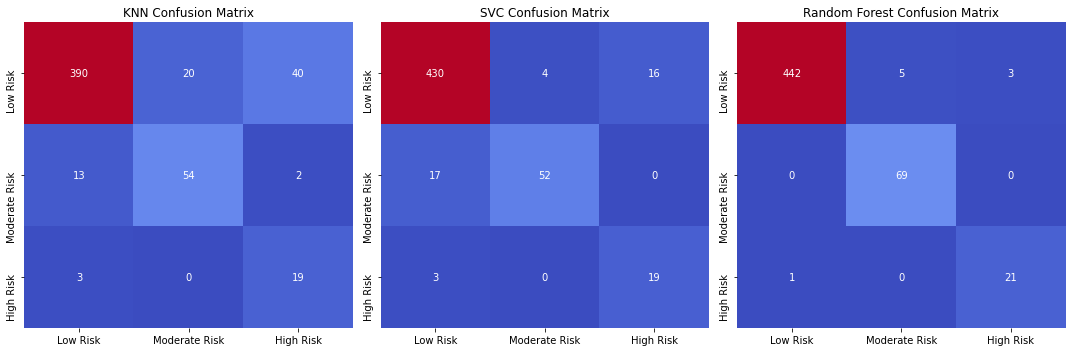

In [92]:
#We first preprocess the data by pipeline
#Then we run the data through each classifier, produce a confusion matrix, f1 score, precision score and accrracy score.
#The confusion matrices are saved as heatmaps and the scores as a csv file
#This serves as a template for repeating this process

directory = '0_REM/'

if not os.path.exists(directory):
    os.makedirs(directory)
    
#Read in the processed data
X_train = pd.read_csv('Train_test_data/X_train.csv')
X_test = pd.read_csv('Train_test_data/X_test.csv')
Y_train = pd.read_csv('Train_test_data/Y_train.csv')
Y_test = pd.read_csv('Train_test_data/Y_test.csv')

train_data = pd.concat([X_train, Y_train], axis=1)
test_data = pd.concat([X_test, Y_test], axis=1)

train_data = null_remove(train_data)
test_data = null_remove(test_data)

X_test = test_data.drop(columns='target')
Y_test = test_data['target']
X_train = train_data.drop(columns='target')
Y_train = train_data['target']

X_train, Y_train  = balancer(X_train, Y_train)



    
#Create our classifiers
knn   = KNeighborsClassifier(n_neighbors = 7)
svc   = SVC(kernel='rbf', C=1.0)
randf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=404)

#fit them to the data
knn.fit(X_train, Y_train)
svc.fit(X_train, Y_train)
randf.fit(X_train, Y_train)

#predict our y values
kkn_y_pred   = knn.predict(X_test)
svc_y_pred   = svc.predict(X_test)
randf_y_pred = randf.predict(X_test)

#Now we get our metrics - we'll group them by classifier
#macro for a more generalisable model, weighted for a better reflection of model performance

knn_conf_matrix = confusion_matrix(Y_test, kkn_y_pred)
knn_f1 = f1_score(Y_test, kkn_y_pred, average='macro') 
knn_precision = precision_score(Y_test, kkn_y_pred, average='macro')
knn_accuracy = accuracy_score(Y_test, kkn_y_pred)

svc_conf_matrix = confusion_matrix(Y_test, svc_y_pred)
svc_f1 = f1_score(Y_test, svc_y_pred, average='macro')
svc_precision = precision_score(Y_test, svc_y_pred, average='macro')
svc_accuracy = accuracy_score(Y_test, svc_y_pred)

randf_conf_matrix = confusion_matrix(Y_test, randf_y_pred)
randf_f1 = f1_score(Y_test, randf_y_pred, average='macro')
randf_precision = precision_score(Y_test, randf_y_pred, average='macro')
randf_accuracy = accuracy_score(Y_test, randf_y_pred)

#Makes the graphs more readable 
class_labels = ['Low Risk', 'Moderate Risk', 'High Risk']

#Plot the confusion matrices for readability abd save the plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.heatmap(knn_conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title('KNN Confusion Matrix')

plt.subplot(1, 3, 2)
sns.heatmap(svc_conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title('SVC Confusion Matrix')

plt.subplot(1, 3, 3)
sns.heatmap(randf_conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title('Random Forest Confusion Matrix')

plt.tight_layout()
plt_name = directory + 'confusion_matrices.png'
plt.savefig(plt_name)
plt.show()

#Turn the results in a dataframe so they can be easily saved as a csv, for comparison purposes
metrics = pd.DataFrame({
    'Model': ['K-nearest Neighbours', 'Support Vector Classification', 'Random Forest'],
    'F1 Score': [knn_f1, svc_f1, randf_f1],
    'Precision': [knn_precision, svc_precision, randf_precision],
    'Accuracy': [knn_accuracy, svc_accuracy, randf_accuracy]
})

file_name = directory + 'metrics.csv'
metrics.to_csv(file_name, index=False)

# 0 MED

C:\Users\LODKe\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\LODKe\anaconda3\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LODKe\anaconda3\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


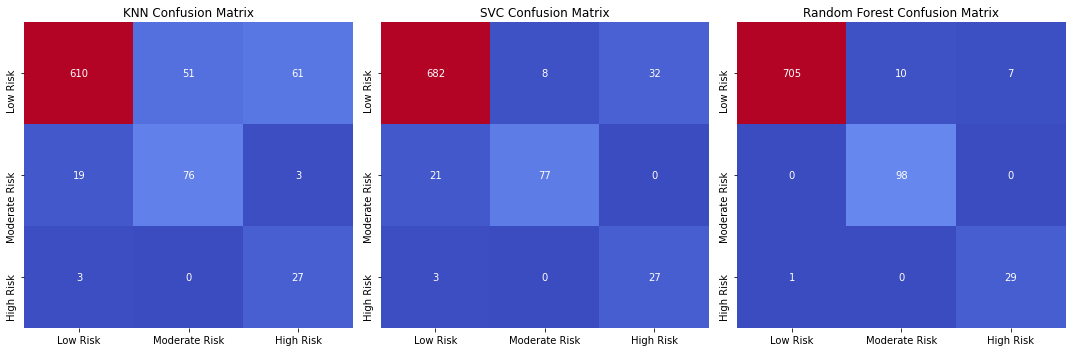

In [93]:
#We first preprocess the data by pipeline
#Then we run the data through each classifier, produce a confusion matrix, f1 score, precision score and accrracy score.
#The confusion matrices are saved as heatmaps and the scores as a csv file
#This serves as a template for repeating this process

directory = '0_MED/'

if not os.path.exists(directory):
    os.makedirs(directory)
    
#Read in the processed data
X_train = pd.read_csv('Train_test_data/X_train.csv')
X_test = pd.read_csv('Train_test_data/X_test.csv')
Y_train = pd.read_csv('Train_test_data/Y_train.csv')
Y_test = pd.read_csv('Train_test_data/Y_test.csv')

#Since median order shouldn't matter but best practice to do test first
X_test = null_impute(X_test, X_train)
X_train = null_impute(X_train, X_train)

X_train, Y_train  = balancer(X_train, Y_train)

#Create our classifiers
knn   = KNeighborsClassifier(n_neighbors = 7)
svc   = SVC(kernel='rbf', C=1.0)
randf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=404)

#fit them to the data
knn.fit(X_train, Y_train)
svc.fit(X_train, Y_train)
randf.fit(X_train, Y_train)

#predict our y values
kkn_y_pred   = knn.predict(X_test)
svc_y_pred   = svc.predict(X_test)
randf_y_pred = randf.predict(X_test)

#Now we get our metrics - we'll group them by classifier
#macro for a more generalisable model, weighted for a better reflection of model performance

knn_conf_matrix = confusion_matrix(Y_test, kkn_y_pred)
knn_f1 = f1_score(Y_test, kkn_y_pred, average='macro') 
knn_precision = precision_score(Y_test, kkn_y_pred, average='macro')
knn_accuracy = accuracy_score(Y_test, kkn_y_pred)

svc_conf_matrix = confusion_matrix(Y_test, svc_y_pred)
svc_f1 = f1_score(Y_test, svc_y_pred, average='macro')
svc_precision = precision_score(Y_test, svc_y_pred, average='macro')
svc_accuracy = accuracy_score(Y_test, svc_y_pred)

randf_conf_matrix = confusion_matrix(Y_test, randf_y_pred)
randf_f1 = f1_score(Y_test, randf_y_pred, average='macro')
randf_precision = precision_score(Y_test, randf_y_pred, average='macro')
randf_accuracy = accuracy_score(Y_test, randf_y_pred)

#Makes the graphs more readable 
class_labels = ['Low Risk', 'Moderate Risk', 'High Risk']

#Plot the confusion matrices for readability abd save the plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.heatmap(knn_conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title('KNN Confusion Matrix')

plt.subplot(1, 3, 2)
sns.heatmap(svc_conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title('SVC Confusion Matrix')

plt.subplot(1, 3, 3)
sns.heatmap(randf_conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title('Random Forest Confusion Matrix')

plt.tight_layout()
plt_name = directory + 'confusion_matrices.png'
plt.savefig(plt_name)
plt.show()

#Turn the results in a dataframe so they can be easily saved as a csv, for comparison purposes
metrics = pd.DataFrame({
    'Model': ['K-nearest Neighbours', 'Support Vector Classification', 'Random Forest'],
    'F1 Score': [knn_f1, svc_f1, randf_f1],
    'Precision': [knn_precision, svc_precision, randf_precision],
    'Accuracy': [knn_accuracy, svc_accuracy, randf_accuracy]
})

file_name = directory + 'metrics.csv'
metrics.to_csv(file_name, index=False)

# 1 REM

C:\Users\LODKe\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\LODKe\anaconda3\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LODKe\anaconda3\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


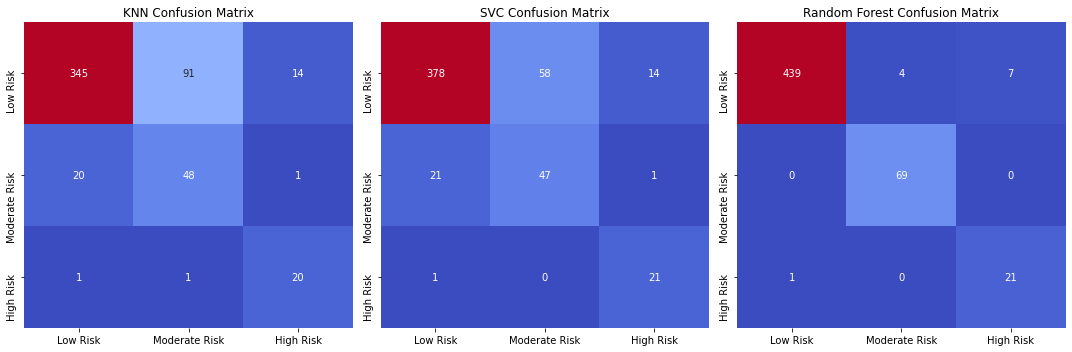

In [95]:
#We first preprocess the data by pipeline
#Then we run the data through each classifier, produce a confusion matrix, f1 score, precision score and accrracy score.
#The confusion matrices are saved as heatmaps and the scores as a csv file
#This serves as a template for repeating this process

directory = '1_REM/'

if not os.path.exists(directory):
    os.makedirs(directory)
    
#Read in the processed data
X_train = pd.read_csv('Train_test_data/X_train.csv')
X_test = pd.read_csv('Train_test_data/X_test.csv')
Y_train = pd.read_csv('Train_test_data/Y_train.csv')
Y_test = pd.read_csv('Train_test_data/Y_test.csv')

#Scale - order matters train last
X_test = standardisation(X_test, X_train)
X_train = standardisation(X_train, X_train)

train_data = pd.concat([X_train, Y_train], axis=1)
test_data = pd.concat([X_test, Y_test], axis=1)

train_data = null_remove(train_data)
test_data = null_remove(test_data)

X_test = test_data.drop(columns='target')
Y_test = test_data['target']
X_train = train_data.drop(columns='target')
Y_train = train_data['target']

X_train, Y_train  = balancer(X_train, Y_train)

#Create our classifiers
knn   = KNeighborsClassifier(n_neighbors = 7)
svc   = SVC(kernel='rbf', C=1.0)
randf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=404)

#fit them to the data
knn.fit(X_train, Y_train)
svc.fit(X_train, Y_train)
randf.fit(X_train, Y_train)

#predict our y values
kkn_y_pred   = knn.predict(X_test)
svc_y_pred   = svc.predict(X_test)
randf_y_pred = randf.predict(X_test)

#Now we get our metrics - we'll group them by classifier
#macro for a more generalisable model, weighted for a better reflection of model performance

knn_conf_matrix = confusion_matrix(Y_test, kkn_y_pred)
knn_f1 = f1_score(Y_test, kkn_y_pred, average='macro') 
knn_precision = precision_score(Y_test, kkn_y_pred, average='macro')
knn_accuracy = accuracy_score(Y_test, kkn_y_pred)

svc_conf_matrix = confusion_matrix(Y_test, svc_y_pred)
svc_f1 = f1_score(Y_test, svc_y_pred, average='macro')
svc_precision = precision_score(Y_test, svc_y_pred, average='macro')
svc_accuracy = accuracy_score(Y_test, svc_y_pred)

randf_conf_matrix = confusion_matrix(Y_test, randf_y_pred)
randf_f1 = f1_score(Y_test, randf_y_pred, average='macro')
randf_precision = precision_score(Y_test, randf_y_pred, average='macro')
randf_accuracy = accuracy_score(Y_test, randf_y_pred)

#Makes the graphs more readable 
class_labels = ['Low Risk', 'Moderate Risk', 'High Risk']

#Plot the confusion matrices for readability abd save the plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.heatmap(knn_conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title('KNN Confusion Matrix')

plt.subplot(1, 3, 2)
sns.heatmap(svc_conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title('SVC Confusion Matrix')

plt.subplot(1, 3, 3)
sns.heatmap(randf_conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title('Random Forest Confusion Matrix')

plt.tight_layout()
plt_name = directory + 'confusion_matrices.png'
plt.savefig(plt_name)
plt.show()

#Turn the results in a dataframe so they can be easily saved as a csv, for comparison purposes
metrics = pd.DataFrame({
    'Model': ['K-nearest Neighbours', 'Support Vector Classification', 'Random Forest'],
    'F1 Score': [knn_f1, svc_f1, randf_f1],
    'Precision': [knn_precision, svc_precision, randf_precision],
    'Accuracy': [knn_accuracy, svc_accuracy, randf_accuracy]
})

file_name = directory + 'metrics.csv'
metrics.to_csv(file_name, index=False)

# 1 MED

C:\Users\LODKe\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\LODKe\anaconda3\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LODKe\anaconda3\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


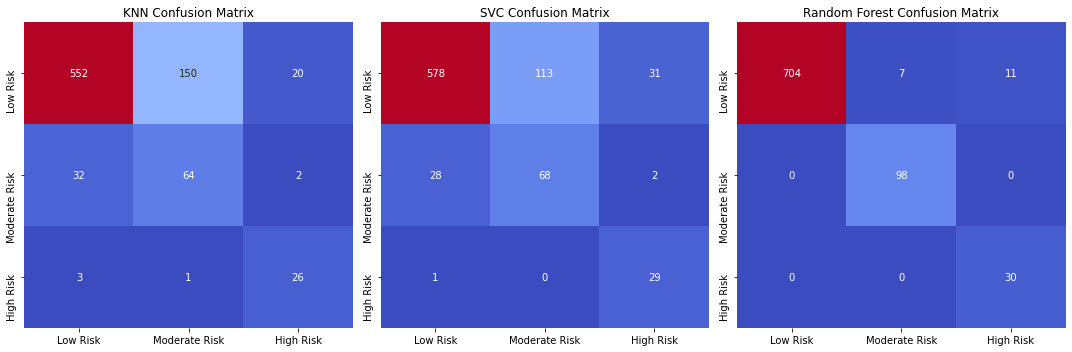

In [96]:
#We first preprocess the data by pipeline
#Then we run the data through each classifier, produce a confusion matrix, f1 score, precision score and accrracy score.
#The confusion matrices are saved as heatmaps and the scores as a csv file
#This serves as a template for repeating this process

directory = '1_MED/'

if not os.path.exists(directory):
    os.makedirs(directory)
    
#Read in the processed data
X_train = pd.read_csv('Train_test_data/X_train.csv')
X_test = pd.read_csv('Train_test_data/X_test.csv')
Y_train = pd.read_csv('Train_test_data/Y_train.csv')
Y_test = pd.read_csv('Train_test_data/Y_test.csv')

#Scale - order matters train last
X_test = standardisation(X_test, X_train)
X_train = standardisation(X_train, X_train)

#Since median order shouldn't matter but best practice to do test first
X_test = null_impute(X_test, X_train)
X_train = null_impute(X_train, X_train)

X_train, Y_train  = balancer(X_train, Y_train)

#Create our classifiers
knn   = KNeighborsClassifier(n_neighbors = 7)
svc   = SVC(kernel='rbf', C=1.0)
randf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=404)

#fit them to the data
knn.fit(X_train, Y_train)
svc.fit(X_train, Y_train)
randf.fit(X_train, Y_train)

#predict our y values
kkn_y_pred   = knn.predict(X_test)
svc_y_pred   = svc.predict(X_test)
randf_y_pred = randf.predict(X_test)

#Now we get our metrics - we'll group them by classifier
#macro for a more generalisable model, weighted for a better reflection of model performance

knn_conf_matrix = confusion_matrix(Y_test, kkn_y_pred)
knn_f1 = f1_score(Y_test, kkn_y_pred, average='macro') 
knn_precision = precision_score(Y_test, kkn_y_pred, average='macro')
knn_accuracy = accuracy_score(Y_test, kkn_y_pred)

svc_conf_matrix = confusion_matrix(Y_test, svc_y_pred)
svc_f1 = f1_score(Y_test, svc_y_pred, average='macro')
svc_precision = precision_score(Y_test, svc_y_pred, average='macro')
svc_accuracy = accuracy_score(Y_test, svc_y_pred)

randf_conf_matrix = confusion_matrix(Y_test, randf_y_pred)
randf_f1 = f1_score(Y_test, randf_y_pred, average='macro')
randf_precision = precision_score(Y_test, randf_y_pred, average='macro')
randf_accuracy = accuracy_score(Y_test, randf_y_pred)

#Makes the graphs more readable 
class_labels = ['Low Risk', 'Moderate Risk', 'High Risk']

#Plot the confusion matrices for readability abd save the plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.heatmap(knn_conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title('KNN Confusion Matrix')

plt.subplot(1, 3, 2)
sns.heatmap(svc_conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title('SVC Confusion Matrix')

plt.subplot(1, 3, 3)
sns.heatmap(randf_conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title('Random Forest Confusion Matrix')

plt.tight_layout()
plt_name = directory + 'confusion_matrices.png'
plt.savefig(plt_name)
plt.show()

#Turn the results in a dataframe so they can be easily saved as a csv, for comparison purposes
metrics = pd.DataFrame({
    'Model': ['K-nearest Neighbours', 'Support Vector Classification', 'Random Forest'],
    'F1 Score': [knn_f1, svc_f1, randf_f1],
    'Precision': [knn_precision, svc_precision, randf_precision],
    'Accuracy': [knn_accuracy, svc_accuracy, randf_accuracy]
})

file_name = directory + 'metrics.csv'
metrics.to_csv(file_name, index=False)

# 1 KNN

C:\Users\LODKe\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\LODKe\anaconda3\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LODKe\anaconda3\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


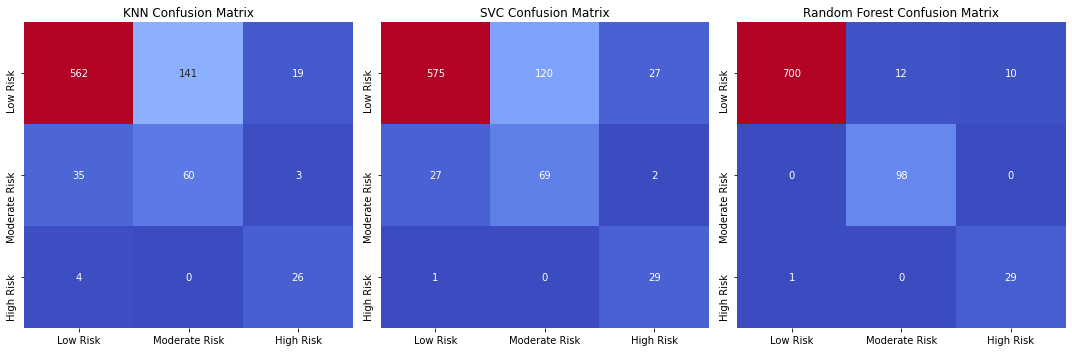

In [97]:
#We first preprocess the data by pipeline
#Then we run the data through each classifier, produce a confusion matrix, f1 score, precision score and accrracy score.
#The confusion matrices are saved as heatmaps and the scores as a csv file
#This serves as a template for repeating this process

directory = '1_KNN/'

if not os.path.exists(directory):
    os.makedirs(directory)
    
#Read in the processed data
X_train = pd.read_csv('Train_test_data/X_train.csv')
X_test = pd.read_csv('Train_test_data/X_test.csv')
Y_train = pd.read_csv('Train_test_data/Y_train.csv')
Y_test = pd.read_csv('Train_test_data/Y_test.csv')

#Scale - order matters train last
X_test = standardisation(X_test, X_train)
X_train = standardisation(X_train, X_train)

#Since - order matters
X_test = null_impute_knn(X_test, X_train)
X_train = null_impute_knn(X_train, X_train)

X_train, Y_train  = balancer(X_train, Y_train)

#Create our classifiers
knn   = KNeighborsClassifier(n_neighbors = 7)
svc   = SVC(kernel='rbf', C=1.0)
randf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=404)

#fit them to the data
knn.fit(X_train, Y_train)
svc.fit(X_train, Y_train)
randf.fit(X_train, Y_train)

#predict our y values
kkn_y_pred   = knn.predict(X_test)
svc_y_pred   = svc.predict(X_test)
randf_y_pred = randf.predict(X_test)

#Now we get our metrics - we'll group them by classifier
#macro for a more generalisable model, weighted for a better reflection of model performance

knn_conf_matrix = confusion_matrix(Y_test, kkn_y_pred)
knn_f1 = f1_score(Y_test, kkn_y_pred, average='macro') 
knn_precision = precision_score(Y_test, kkn_y_pred, average='macro')
knn_accuracy = accuracy_score(Y_test, kkn_y_pred)

svc_conf_matrix = confusion_matrix(Y_test, svc_y_pred)
svc_f1 = f1_score(Y_test, svc_y_pred, average='macro')
svc_precision = precision_score(Y_test, svc_y_pred, average='macro')
svc_accuracy = accuracy_score(Y_test, svc_y_pred)

randf_conf_matrix = confusion_matrix(Y_test, randf_y_pred)
randf_f1 = f1_score(Y_test, randf_y_pred, average='macro')
randf_precision = precision_score(Y_test, randf_y_pred, average='macro')
randf_accuracy = accuracy_score(Y_test, randf_y_pred)

#Makes the graphs more readable 
class_labels = ['Low Risk', 'Moderate Risk', 'High Risk']

#Plot the confusion matrices for readability abd save the plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.heatmap(knn_conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title('KNN Confusion Matrix')

plt.subplot(1, 3, 2)
sns.heatmap(svc_conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title('SVC Confusion Matrix')

plt.subplot(1, 3, 3)
sns.heatmap(randf_conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title('Random Forest Confusion Matrix')

plt.tight_layout()
plt_name = directory + 'confusion_matrices.png'
plt.savefig(plt_name)
plt.show()

#Turn the results in a dataframe so they can be easily saved as a csv, for comparison purposes
metrics = pd.DataFrame({
    'Model': ['K-nearest Neighbours', 'Support Vector Classification', 'Random Forest'],
    'F1 Score': [knn_f1, svc_f1, randf_f1],
    'Precision': [knn_precision, svc_precision, randf_precision],
    'Accuracy': [knn_accuracy, svc_accuracy, randf_accuracy]
})

file_name = directory + 'metrics.csv'
metrics.to_csv(file_name, index=False)

# 1 DB KNN

Total number of outliers identified is:  144


C:\Users\LODKe\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\LODKe\anaconda3\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LODKe\anaconda3\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


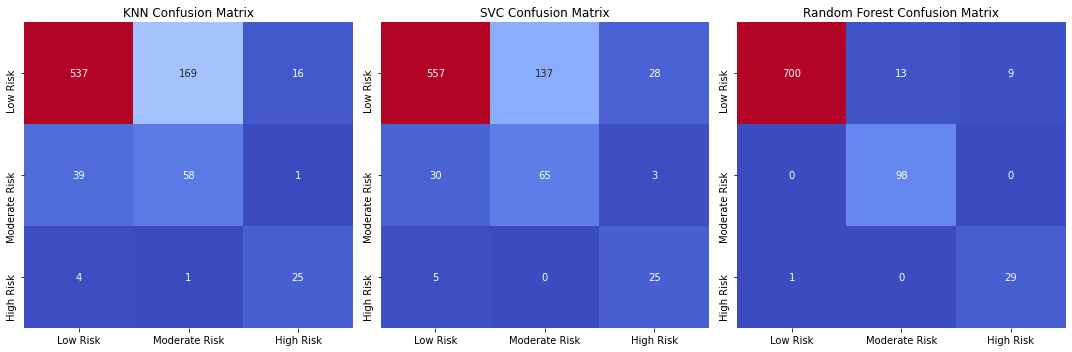

In [115]:
#We first preprocess the data by pipeline
#Then we run the data through each classifier, produce a confusion matrix, f1 score, precision score and accrracy score.
#The confusion matrices are saved as heatmaps and the scores as a csv file
#This serves as a template for repeating this process

directory = '1_DB_KNN/'

if not os.path.exists(directory):
    os.makedirs(directory)
    
#Read in the processed data
X_train = pd.read_csv('Train_test_data/X_train.csv')
X_test = pd.read_csv('Train_test_data/X_test.csv')
Y_train = pd.read_csv('Train_test_data/Y_train.csv')
Y_test = pd.read_csv('Train_test_data/Y_test.csv')

#Scale - order matters train last
X_test = standardisation(X_test, X_train)
X_train = standardisation(X_train, X_train)

#null - order matters
X_test = null_impute_knn(X_test, X_train)
X_train = null_impute_knn(X_train, X_train)

#since outlier detection may remove rows
train_data = pd.concat([X_train, Y_train], axis=1)

#DBscan - only remove outliers from train, 
train_data =  outlier_removal_DB(train_data)

X_train = train_data.drop(columns='target')
Y_train = train_data['target']


X_train, Y_train  = balancer(X_train, Y_train)

#Create our classifiers
knn   = KNeighborsClassifier(n_neighbors = 7)
svc   = SVC(kernel='rbf', C=1.0)
randf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=404)

#fit them to the data
knn.fit(X_train, Y_train)
svc.fit(X_train, Y_train)
randf.fit(X_train, Y_train)

#predict our y values
kkn_y_pred   = knn.predict(X_test)
svc_y_pred   = svc.predict(X_test)
randf_y_pred = randf.predict(X_test)

#Now we get our metrics - we'll group them by classifier
#macro for a more generalisable model, weighted for a better reflection of model performance

knn_conf_matrix = confusion_matrix(Y_test, kkn_y_pred)
knn_f1 = f1_score(Y_test, kkn_y_pred, average='macro') 
knn_precision = precision_score(Y_test, kkn_y_pred, average='macro')
knn_accuracy = accuracy_score(Y_test, kkn_y_pred)

svc_conf_matrix = confusion_matrix(Y_test, svc_y_pred)
svc_f1 = f1_score(Y_test, svc_y_pred, average='macro')
svc_precision = precision_score(Y_test, svc_y_pred, average='macro')
svc_accuracy = accuracy_score(Y_test, svc_y_pred)

randf_conf_matrix = confusion_matrix(Y_test, randf_y_pred)
randf_f1 = f1_score(Y_test, randf_y_pred, average='macro')
randf_precision = precision_score(Y_test, randf_y_pred, average='macro')
randf_accuracy = accuracy_score(Y_test, randf_y_pred)

#Makes the graphs more readable 
class_labels = ['Low Risk', 'Moderate Risk', 'High Risk']

#Plot the confusion matrices for readability abd save the plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.heatmap(knn_conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title('KNN Confusion Matrix')

plt.subplot(1, 3, 2)
sns.heatmap(svc_conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title('SVC Confusion Matrix')

plt.subplot(1, 3, 3)
sns.heatmap(randf_conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title('Random Forest Confusion Matrix')

plt.tight_layout()
plt_name = directory + 'confusion_matrices.png'
plt.savefig(plt_name)
plt.show()

#Turn the results in a dataframe so they can be easily saved as a csv, for comparison purposes
metrics = pd.DataFrame({
    'Model': ['K-nearest Neighbours', 'Support Vector Classification', 'Random Forest'],
    'F1 Score': [knn_f1, svc_f1, randf_f1],
    'Precision': [knn_precision, svc_precision, randf_precision],
    'Accuracy': [knn_accuracy, svc_accuracy, randf_accuracy]
})

file_name = directory + 'metrics.csv'
metrics.to_csv(file_name, index=False)

# 1 ISF KNN

C:\Users\LODKe\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:307: UserWarning: max_samples (4250) is greater than the total number of samples (3398). max_samples will be set to n_samples for estimation.
  warn(


Total number of outliers identified is:  170


C:\Users\LODKe\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\LODKe\anaconda3\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LODKe\anaconda3\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


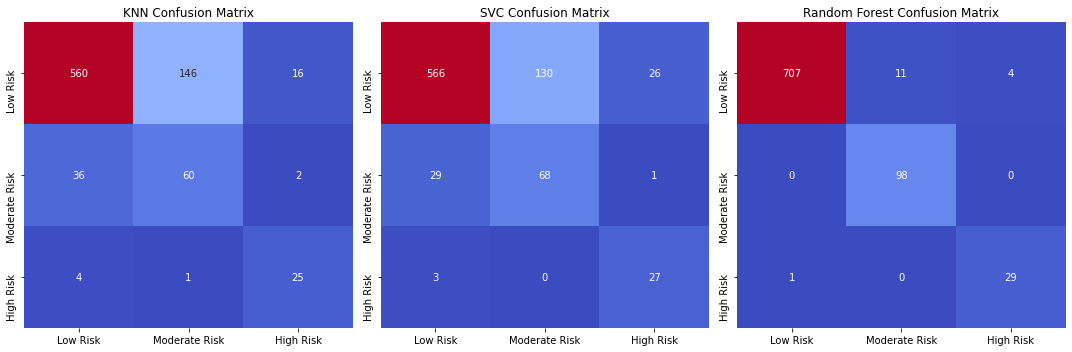

In [116]:
#We first preprocess the data by pipeline
#Then we run the data through each classifier, produce a confusion matrix, f1 score, precision score and accrracy score.
#The confusion matrices are saved as heatmaps and the scores as a csv file
#This serves as a template for repeating this process

directory = '1_ISF_KNN/'

if not os.path.exists(directory):
    os.makedirs(directory)
    
#Read in the processed data
X_train = pd.read_csv('Train_test_data/X_train.csv')
X_test = pd.read_csv('Train_test_data/X_test.csv')
Y_train = pd.read_csv('Train_test_data/Y_train.csv')
Y_test = pd.read_csv('Train_test_data/Y_test.csv')

#Scale - order matters train last
X_test = standardisation(X_test, X_train)
X_train = standardisation(X_train, X_train)

#null - order matters
X_test = null_impute_knn(X_test, X_train)
X_train = null_impute_knn(X_train, X_train)

#since outlier detection may remove rows
train_data = pd.concat([X_train, Y_train], axis=1)

#ISF - only remove outliers from train, 
train_data =  outlier_removal_ISF(train_data)

X_train = train_data.drop(columns='target')
Y_train = train_data['target']

X_train, Y_train  = balancer(X_train, Y_train)

#Create our classifiers
knn   = KNeighborsClassifier(n_neighbors = 7)
svc   = SVC(kernel='rbf', C=1.0)
randf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=404)

#fit them to the data
knn.fit(X_train, Y_train)
svc.fit(X_train, Y_train)
randf.fit(X_train, Y_train)

#predict our y values
kkn_y_pred   = knn.predict(X_test)
svc_y_pred   = svc.predict(X_test)
randf_y_pred = randf.predict(X_test)

#Now we get our metrics - we'll group them by classifier
#macro for a more generalisable model, weighted for a better reflection of model performance

knn_conf_matrix = confusion_matrix(Y_test, kkn_y_pred)
knn_f1 = f1_score(Y_test, kkn_y_pred, average='macro') 
knn_precision = precision_score(Y_test, kkn_y_pred, average='macro')
knn_accuracy = accuracy_score(Y_test, kkn_y_pred)

svc_conf_matrix = confusion_matrix(Y_test, svc_y_pred)
svc_f1 = f1_score(Y_test, svc_y_pred, average='macro')
svc_precision = precision_score(Y_test, svc_y_pred, average='macro')
svc_accuracy = accuracy_score(Y_test, svc_y_pred)

randf_conf_matrix = confusion_matrix(Y_test, randf_y_pred)
randf_f1 = f1_score(Y_test, randf_y_pred, average='macro')
randf_precision = precision_score(Y_test, randf_y_pred, average='macro')
randf_accuracy = accuracy_score(Y_test, randf_y_pred)

#Makes the graphs more readable 
class_labels = ['Low Risk', 'Moderate Risk', 'High Risk']

#Plot the confusion matrices for readability abd save the plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.heatmap(knn_conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title('KNN Confusion Matrix')

plt.subplot(1, 3, 2)
sns.heatmap(svc_conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title('SVC Confusion Matrix')

plt.subplot(1, 3, 3)
sns.heatmap(randf_conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title('Random Forest Confusion Matrix')

plt.tight_layout()
plt_name = directory + 'confusion_matrices.png'
plt.savefig(plt_name)
plt.show()

#Turn the results in a dataframe so they can be easily saved as a csv, for comparison purposes
metrics = pd.DataFrame({
    'Model': ['K-nearest Neighbours', 'Support Vector Classification', 'Random Forest'],
    'F1 Score': [knn_f1, svc_f1, randf_f1],
    'Precision': [knn_precision, svc_precision, randf_precision],
    'Accuracy': [knn_accuracy, svc_accuracy, randf_accuracy]
})

file_name = directory + 'metrics.csv'
metrics.to_csv(file_name, index=False)

# 1 LOF KNN

Total number of outliers identified is:  170


C:\Users\LODKe\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\LODKe\anaconda3\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LODKe\anaconda3\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


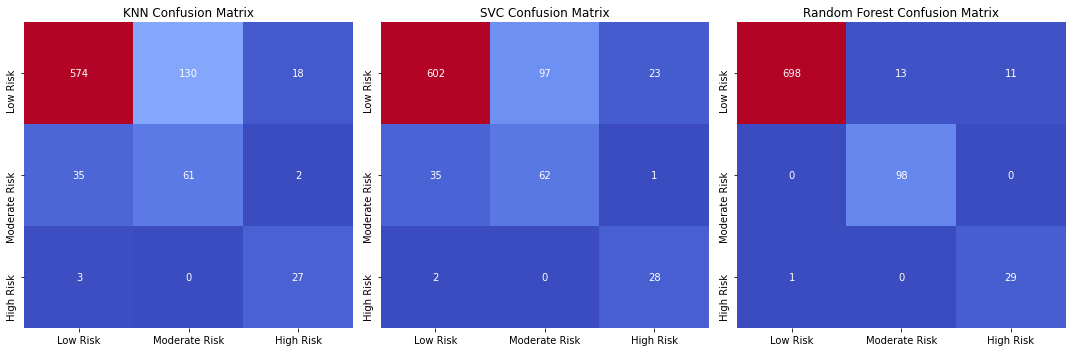

In [117]:
#We first preprocess the data by pipeline
#Then we run the data through each classifier, produce a confusion matrix, f1 score, precision score and accrracy score.
#The confusion matrices are saved as heatmaps and the scores as a csv file
#This serves as a template for repeating this process

directory = '1_LOF_KNN/'

if not os.path.exists(directory):
    os.makedirs(directory)
    
#Read in the processed data
X_train = pd.read_csv('Train_test_data/X_train.csv')
X_test = pd.read_csv('Train_test_data/X_test.csv')
Y_train = pd.read_csv('Train_test_data/Y_train.csv')
Y_test = pd.read_csv('Train_test_data/Y_test.csv')

#Scale - order matters train last
X_test = standardisation(X_test, X_train)
X_train = standardisation(X_train, X_train)

#null - order matters
X_test = null_impute_knn(X_test, X_train)
X_train = null_impute_knn(X_train, X_train)

#since outlier detection may remove rows
train_data = pd.concat([X_train, Y_train], axis=1)

#ISF - only remove outliers from train, 
train_data =  outlier_removal_LOF(train_data)

X_train = train_data.drop(columns='target')
Y_train = train_data['target']

X_train, Y_train  = balancer(X_train, Y_train)

#Create our classifiers
knn   = KNeighborsClassifier(n_neighbors = 7)
svc   = SVC(kernel='rbf', C=1.0)
randf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=404)

#fit them to the data
knn.fit(X_train, Y_train)
svc.fit(X_train, Y_train)
randf.fit(X_train, Y_train)

#predict our y values
kkn_y_pred   = knn.predict(X_test)
svc_y_pred   = svc.predict(X_test)
randf_y_pred = randf.predict(X_test)

#Now we get our metrics - we'll group them by classifier
#macro for a more generalisable model, weighted for a better reflection of model performance

knn_conf_matrix = confusion_matrix(Y_test, kkn_y_pred)
knn_f1 = f1_score(Y_test, kkn_y_pred, average='macro') 
knn_precision = precision_score(Y_test, kkn_y_pred, average='macro')
knn_accuracy = accuracy_score(Y_test, kkn_y_pred)

svc_conf_matrix = confusion_matrix(Y_test, svc_y_pred)
svc_f1 = f1_score(Y_test, svc_y_pred, average='macro')
svc_precision = precision_score(Y_test, svc_y_pred, average='macro')
svc_accuracy = accuracy_score(Y_test, svc_y_pred)

randf_conf_matrix = confusion_matrix(Y_test, randf_y_pred)
randf_f1 = f1_score(Y_test, randf_y_pred, average='macro')
randf_precision = precision_score(Y_test, randf_y_pred, average='macro')
randf_accuracy = accuracy_score(Y_test, randf_y_pred)

#Makes the graphs more readable 
class_labels = ['Low Risk', 'Moderate Risk', 'High Risk']

#Plot the confusion matrices for readability abd save the plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.heatmap(knn_conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title('KNN Confusion Matrix')

plt.subplot(1, 3, 2)
sns.heatmap(svc_conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title('SVC Confusion Matrix')

plt.subplot(1, 3, 3)
sns.heatmap(randf_conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title('Random Forest Confusion Matrix')

plt.tight_layout()
plt_name = directory + 'confusion_matrices.png'
plt.savefig(plt_name)
plt.show()

#Turn the results in a dataframe so they can be easily saved as a csv, for comparison purposes
metrics = pd.DataFrame({
    'Model': ['K-nearest Neighbours', 'Support Vector Classification', 'Random Forest'],
    'F1 Score': [knn_f1, svc_f1, randf_f1],
    'Precision': [knn_precision, svc_precision, randf_precision],
    'Accuracy': [knn_accuracy, svc_accuracy, randf_accuracy]
})

file_name = directory + 'metrics.csv'
metrics.to_csv(file_name, index=False)

# 1 DBLOF KNN

Total number of outliers identified is:  255
Total number of outliers identified is:  650
[ True  True  True ...  True  True  True]
[False  True  True ...  True  True  True]
[ True  True  True ...  True  True  True]
Total number of outliers identified is:  176


C:\Users\LODKe\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\LODKe\anaconda3\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LODKe\anaconda3\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


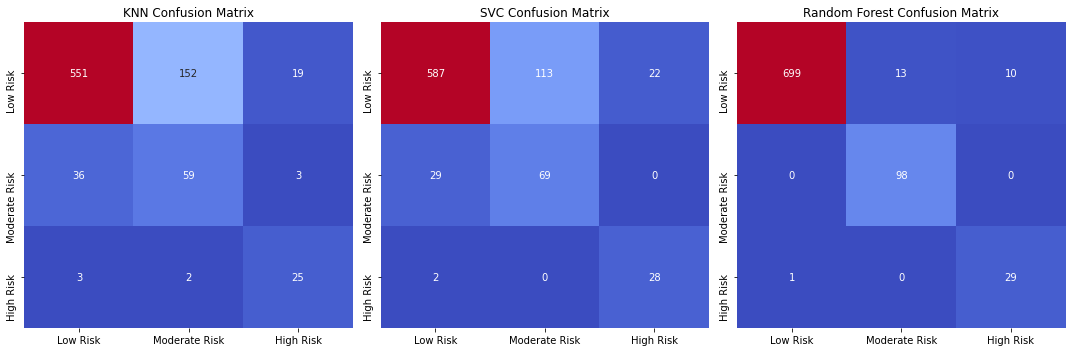

In [134]:
#We first preprocess the data by pipeline
#Then we run the data through each classifier, produce a confusion matrix, f1 score, precision score and accrracy score.
#The confusion matrices are saved as heatmaps and the scores as a csv file
#This serves as a template for repeating this process

directory = '1_DBLOF_KNN/'

if not os.path.exists(directory):
    os.makedirs(directory)
    
#Read in the processed data
X_train = pd.read_csv('Train_test_data/X_train.csv')
X_test = pd.read_csv('Train_test_data/X_test.csv')
Y_train = pd.read_csv('Train_test_data/Y_train.csv')
Y_test = pd.read_csv('Train_test_data/Y_test.csv')

#Scale - order matters train last
X_test = standardisation(X_test, X_train)
X_train = standardisation(X_train, X_train)

#null - order matters
X_test = null_impute_knn(X_test, X_train)
X_train = null_impute_knn(X_train, X_train)

#since outlier detection may remove rows
train_data = pd.concat([X_train, Y_train], axis=1)

#ISF - only remove outliers from train, 
train_data =  outlier_removal_DBLOF(train_data)

X_train = train_data.drop(columns='target')
Y_train = train_data['target']

X_train, Y_train  = balancer(X_train, Y_train)

#Create our classifiers
knn   = KNeighborsClassifier(n_neighbors = 7)
svc   = SVC(kernel='rbf', C=1.0)
randf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=404)

#fit them to the data
knn.fit(X_train, Y_train)
svc.fit(X_train, Y_train)
randf.fit(X_train, Y_train)

#predict our y values
kkn_y_pred   = knn.predict(X_test)
svc_y_pred   = svc.predict(X_test)
randf_y_pred = randf.predict(X_test)

#Now we get our metrics - we'll group them by classifier
#macro for a more generalisable model, weighted for a better reflection of model performance

knn_conf_matrix = confusion_matrix(Y_test, kkn_y_pred)
knn_f1 = f1_score(Y_test, kkn_y_pred, average='macro') 
knn_precision = precision_score(Y_test, kkn_y_pred, average='macro')
knn_accuracy = accuracy_score(Y_test, kkn_y_pred)

svc_conf_matrix = confusion_matrix(Y_test, svc_y_pred)
svc_f1 = f1_score(Y_test, svc_y_pred, average='macro')
svc_precision = precision_score(Y_test, svc_y_pred, average='macro')
svc_accuracy = accuracy_score(Y_test, svc_y_pred)

randf_conf_matrix = confusion_matrix(Y_test, randf_y_pred)
randf_f1 = f1_score(Y_test, randf_y_pred, average='macro')
randf_precision = precision_score(Y_test, randf_y_pred, average='macro')
randf_accuracy = accuracy_score(Y_test, randf_y_pred)

#Makes the graphs more readable 
class_labels = ['Low Risk', 'Moderate Risk', 'High Risk']

#Plot the confusion matrices for readability abd save the plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.heatmap(knn_conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title('KNN Confusion Matrix')

plt.subplot(1, 3, 2)
sns.heatmap(svc_conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title('SVC Confusion Matrix')

plt.subplot(1, 3, 3)
sns.heatmap(randf_conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title('Random Forest Confusion Matrix')

plt.tight_layout()
plt_name = directory + 'confusion_matrices.png'
plt.savefig(plt_name)
plt.show()

#Turn the results in a dataframe so they can be easily saved as a csv, for comparison purposes
metrics = pd.DataFrame({
    'Model': ['K-nearest Neighbours', 'Support Vector Classification', 'Random Forest'],
    'F1 Score': [knn_f1, svc_f1, randf_f1],
    'Precision': [knn_precision, svc_precision, randf_precision],
    'Accuracy': [knn_accuracy, svc_accuracy, randf_accuracy]
})

file_name = directory + 'metrics.csv'
metrics.to_csv(file_name, index=False)

Ignoring the results from the removal sets, which we'll treat as something to aim for since while they have the best accurracy, the complete removal of information might not be ideal. If however a model is not found that outperforms these then I may end up using one. As for results outside the best it appears to be 1_ISF_KNN i.e. scaled, isolated forest to remove outliers, knn imputation and calssification with random forest. 

Random forest has performed the best thus far but we can test if this is because it performs better with the data or simply has better parameters. We do so with a grid test, because this is a relatively intense process we'll start with just one model and see how far we can take it.

In [144]:
test = [[1,2,3],[4,5,6],[7,8,9]]

print(test)
fp = print(test[1][0], test[2][0], test[2][1])



[[1, 2, 3], [4, 5, 6], [7, 8, 9]]
4 7 8


In [164]:
#We first preprocess the data by pipeline
#Then we run the data through each classifier, produce a confusion matrix, f1 score, precision score and accrracy score.
#The confusion matrices are saved as heatmaps and the scores as a csv file
#This serves as a template for repeating this process

directory = '1_LOF_KNN_GRIDSEARCH/'

if not os.path.exists(directory):
    os.makedirs(directory)
    
#Read in the processed data
X_train = pd.read_csv('Train_test_data/X_train.csv')
X_test = pd.read_csv('Train_test_data/X_test.csv')
Y_train = pd.read_csv('Train_test_data/Y_train.csv')
Y_test = pd.read_csv('Train_test_data/Y_test.csv')

#Scale - order matters train last
X_test = standardisation(X_test, X_train)
X_train = standardisation(X_train, X_train)

#null - order matters
X_test = null_impute_knn(X_test, X_train)
X_train = null_impute_knn(X_train, X_train)

#since outlier detection may remove rows
train_data = pd.concat([X_train, Y_train], axis=1)

#ISF - only remove outliers from train, 
train_data =  outlier_removal_LOF(train_data)

X_train = train_data.drop(columns='target')
Y_train = train_data['target']

X_train, Y_train  = balancer(X_train, Y_train)

#Create a parameter space to explore
param_grid_knn = {
                  'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19]
                 }
param_grid_svc = {
                  'kernel': ['rbf', 'poly', 'sigmoid']
                  'C': [0.1, 1, 10, 100]
                 }

param_grid_randf = {
                    'n_estimators': [50, 100, 200],
                    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]
                   }

#Create our classifiers -= these are technically parameters
models = {
          'knn'   : (KNeighborsClassifier(), param_grid_knn),
          'svc'   : (SVC(kernel='rbf'), param_grid_svc),
          'randf' : (RandomForestClassifier(random_state=404), param_grid_randf)
         }

#Create score to minimise results in certain parts of the confusion matrix
def under_diagnosis_rate(Y_test, Y_pred):
    matrix = confusion_matrix(Y_test, Y_pred)
    under_diagnosis = matrix[1][0] + matrix[2][0] + matrix[2][1]
    all_predictions = np.sum(matrix)
    under_diagnosis_rate = (under_diagnosis) / (all_predictions)

    return under_diagnosis_rate

def over_diagnosis_rate(Y_test, Y_pred):
    matrix = confusion_matrix(Y_test, Y_pred)
    over_diagnosis = matrix[0][1] + matrix[0][2] + matrix[1][2]
    all_predictions = np.sum(matrix)
    over_diagnosis_rate = (over_diagnosis) / (all_predictions)    
    
    return over_diagnosis_rate

#Define scoring functions
scores = {
    'f1': make_scorer(f1_score, average='weighted'),
    'under_diagnosis': make_scorer(under_diagnosis_rate, greater_is_better=False),
    'over_diagnosis': make_scorer(over_diagnosis_rate, greater_is_better=False)
}


def grid_search(model, param_grid, score, X_train, Y_train):
    print('-')
    grid_search = GridSearchCV(model, param_grid, scoring=score, cv=10, n_jobs=-1)
    grid_search.fit(X_train, Y_train)
    return grid_search


best_models = {}
results = []

for model_name, (model, model_params) in models.items():
    for score_name, score in scores.items():
        print('Running Grid search of model:', model_name, 'with a score', score_name)
        grid_searched = grid_search(model, model_params, score, X_train, Y_train)
        model = grid_searched.best_estimator_
        name = model_name + score_name
        best_models[name] = model
        
        #saving our best performing model
        path = directory + name
        with open (path, 'wb') as file:
            pickle.dump(model, file)
        
        #create metrics
        Y_pred = model.predict(X_test)
        matrix = confusion_matrix(Y_test, Y_pred)
        f1 = f1_score(Y_test, Y_pred, average='weighted')
        precision = precision_score(Y_test, Y_pred, average='weighted')
        accuracy = accuracy_score(Y_test, Y_pred)
        under_score = under_diagnosis_rate(Y_test, Y_pred)
        over_score =  over_diagnosis_rate(Y_test, Y_pred)
        results.append({
                        'Model':            name,
                        'F1 Score':         f1,
                        'Precision':        precision,
                        'Accuracy':         accuracy,
                        'Confusion Matrix': matrix,
                        'Under_diagnosis':  under_score,
                        'Over_diagnosis':   over_score,
                       })

#From metrics we create a dataframe to be able to search for the best model
metrics_data = pd.DataFrame(results)
metrics_name = directory + 'metrics.csv'
metrics_data.to_csv(metrics_name, index=False)
        
print('done')
# #fit them to the data
# knn.fit(X_train, Y_train)
# svc.fit(X_train, Y_train)
# randf.fit(X_train, Y_train)

# #predict our y values
# kkn_y_pred   = knn.predict(X_test)
# svc_y_pred   = svc.predict(X_test)
# randf_y_pred = randf.predict(X_test)

# #Now we get our metrics - we'll group them by classifier
# #macro for a more generalisable model, weighted for a better reflection of model performance

# knn_conf_matrix = confusion_matrix(Y_test, kkn_y_pred)
# knn_f1 = f1_score(Y_test, kkn_y_pred, average='macro') 
# knn_precision = precision_score(Y_test, kkn_y_pred, average='macro')
# knn_accuracy = accuracy_score(Y_test, kkn_y_pred)

# svc_conf_matrix = confusion_matrix(Y_test, svc_y_pred)
# svc_f1 = f1_score(Y_test, svc_y_pred, average='macro')
# svc_precision = precision_score(Y_test, svc_y_pred, average='macro')
# svc_accuracy = accuracy_score(Y_test, svc_y_pred)

# randf_conf_matrix = confusion_matrix(Y_test, randf_y_pred)
# randf_f1 = f1_score(Y_test, randf_y_pred, average='macro')
# randf_precision = precision_score(Y_test, randf_y_pred, average='macro')
# randf_accuracy = accuracy_score(Y_test, randf_y_pred)

# #Makes the graphs more readable 
# class_labels = ['Low Risk', 'Moderate Risk', 'High Risk']

# #Plot the confusion matrices for readability abd save the plot
# plt.figure(figsize=(15, 5))
# plt.subplot(1, 3, 1)
# sns.heatmap(knn_conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
# plt.title('KNN Confusion Matrix')

# plt.subplot(1, 3, 2)
# sns.heatmap(svc_conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
# plt.title('SVC Confusion Matrix')

# plt.subplot(1, 3, 3)
# sns.heatmap(randf_conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
# plt.title('Random Forest Confusion Matrix')

# plt.tight_layout()
# plt_name = directory + 'confusion_matrices.png'
# plt.savefig(plt_name)
# plt.show()

# #Turn the results in a dataframe so they can be easily saved as a csv, for comparison purposes
# metrics = pd.DataFrame({
#     'Model': ['K-nearest Neighbours', 'Support Vector Classification', 'Random Forest'],
#     'F1 Score': [knn_f1, svc_f1, randf_f1],
#     'Precision': [knn_precision, svc_precision, randf_precision],
#     'Accuracy': [knn_accuracy, svc_accuracy, randf_accuracy]
# })

# file_name = directory + 'metrics.csv'
# metrics.to_csv(file_name, index=False)

Total number of outliers identified is:  170
Running Grid search of model: knn with a score f1
-


C:\Users\LODKe\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Running Grid search of model: knn with a score under_diagnosis
-


C:\Users\LODKe\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Running Grid search of model: knn with a score over_diagnosis
-


C:\Users\LODKe\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Running Grid search of model: svc with a score f1
-


C:\Users\LODKe\anaconda3\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Running Grid search of model: svc with a score under_diagnosis
-


C:\Users\LODKe\anaconda3\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Running Grid search of model: svc with a score over_diagnosis
-


C:\Users\LODKe\anaconda3\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Running Grid search of model: randf with a score f1
-


C:\Users\LODKe\anaconda3\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Running Grid search of model: randf with a score under_diagnosis
-


C:\Users\LODKe\anaconda3\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Running Grid search of model: randf with a score over_diagnosis
-


C:\Users\LODKe\anaconda3\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


done


We find that reliably Random forest is the best performing. Feature importance is stored in random forest so I can get it directly

In [170]:
path = '1_LOF_KNN_GRIDSEARCH/randfunder_diagnosis'

with open (path, 'rb') as file:
    model = pickle.load(file)

importances = model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

          Feature  Importance
0         test_X1    0.346420
3         test_X2    0.199959
1         test_X5    0.187961
2         test_X3    0.161595
4         test_X4    0.037206
5   concern_type2    0.030449
7             age    0.014964
8    medication_A    0.009377
6         suspect    0.003143
10        G_empty    0.002987
11       G_female    0.002622
12         G_male    0.002140
9    medication_B    0.001176


In [ ]:
file = open("Fruits.obj",'rb')


Tried to make pipelines work, but unforunately they have limited interactability without being able to make custom transformer functions. I don't know how to do this and don't think I have the time to learn how to for this project

In [8]:
# #Template pipeline
# Initial_processing = Pipeline([
#     ('clean', FunctionTransformer(clean_data)),
#     ('encode', FunctionTransformer(encode)),
#     ('split', FunctionTransformer(train_test_split)),
#     ...
#     ('balance' FunctionTransformer(balancer)),
# ])

#Specific pipelines
# KEY
#_0 for no scaling _1 for scaling
#_REM for null removal, _MED for median imputation _KNN for knn imputation
#_DB for DBscan, _LOF for local outlier factor, _ISF for isolation forest, _DBLOF for DB + LOF

pipline_0_REM = Pipeline([
    ('clean',         FunctionTransformer(clean_data)),
    ('encode',        FunctionTransformer(encode)),
    ('split',         FunctionTransformer(train_test_only_split)),
    ('null handling', FunctionTransformer(null_remove)),
    ('balance',       FunctionTransformer(balancer)),
])

pipline_0_MED = Pipeline([
    ('clean',         FunctionTransformer(clean_data)),
    ('encode',        FunctionTransformer(encode)),
    ('split',         FunctionTransformer(train_test_only_split)),
    ('null handling', FunctionTransformer(lambda X: null_impute(X, X_train))),
    ('balance',       FunctionTransformer(balancer)),
])

pipline_1_REM = Pipeline([
    ('clean',         FunctionTransformer(clean_data)),
    ('encode',        FunctionTransformer(encode)),
    ('split',         FunctionTransformer(train_test_only_split)),
    ('scale',         FunctionTransformer(lambda X: standardisation(X, X_train))),
    ('null handling', FunctionTransformer(null_remove)),
    ('balance',       FunctionTransformer(balancer)),
])

pipline_1_MED = Pipeline([
    ('clean',         FunctionTransformer(clean_data)),
    ('encode',        FunctionTransformer(encode)),
    ('split',         FunctionTransformer(train_test_only_split)),
    ('scale',         FunctionTransformer(standardisation)),
    ('null handling', FunctionTransformer(lambda X: null_impute(X, X_train))),
    ('balance',       FunctionTransformer(balancer)),
])

pipline_1_KNN = Pipeline([
    ('clean',         FunctionTransformer(clean_data)),
    ('encode',        FunctionTransformer(encode)),
    ('split',         FunctionTransformer(train_test_only_split)),
    ('scale',         FunctionTransformer(lambda X: standardisation(X, X_train))),
    ('null handling', FunctionTransformer(lambda X: null_impute_knn(X, X_train))),
    ('balance',       FunctionTransformer(balancer)),
])

pipline_1_DB_KNN = Pipeline([
    ('clean',         FunctionTransformer(clean_data)),
    ('encode',        FunctionTransformer(encode)),
    ('split',         FunctionTransformer(train_test_only_split)),
    ('scale',         FunctionTransformer(lambda X: standardisation(X, X_train))),
    ('outlier removal', FunctionTransformer()), #PLace hollder
    ('null handling', FunctionTransformer(lambda X: null_impute_knn(X, X_train))),
    ('balance',       FunctionTransformer(balancer)),
])

pipline_1_ISF_KNN = Pipeline([
    ('clean',         FunctionTransformer(clean_data)),
    ('encode',        FunctionTransformer(encode)),
    ('split',         FunctionTransformer(train_test_only_split)),
    ('scale',         FunctionTransformer(lambda X: standardisation(X, X_train))),
    ('outlier removal', FunctionTransformer()), #PLace hollder
    ('null handling', FunctionTransformer(lambda X: null_impute_knn(X, X_train))),
    ('balance',       FunctionTransformer(balancer)),
])
      
pipline_1_LOF_KNN = Pipeline([
    ('clean',         FunctionTransformer(clean_data)),
    ('encode',        FunctionTransformer(encode)),
    ('split',         FunctionTransformer(train_test_only_split)),
    ('scale',         FunctionTransformer(lambda X: standardisation(X, X_train))),
    ('outlier removal', FunctionTransformer()), #PLace hollder
    ('null handling', FunctionTransformer(lambda X: null_impute_knn(X, X_train))),
    ('balance',       FunctionTransformer(balancer)),
])

pipline_1_DBLOF_KNN = Pipeline([
    ('clean',         FunctionTransformer(clean_data)),
    ('encode',        FunctionTransformer(encode)),
    ('split',         FunctionTransformer(train_test_only_split)),
    ('scale',         FunctionTransformer(lambda X: standardisation(X, X_train))),
    ('outlier removal', FunctionTransformer()), #PLace hollder
    ('null handling', FunctionTransformer(lambda X: null_impute_knn(X, X_train))),
    ('balance',       FunctionTransformer(balancer)),
])

In [22]:
# Define your pipeline
pipeline = Pipeline([
    ('split', FunctionTransformer(lambda X: train_test_split(X, test_size=0.2, random_state=42))),
    ('null_remove', FunctionTransformer(null_remove)),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier())
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Predict using the pipeline
y_pred = pipeline.predict(X_test)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

NameError: name 'X_train' is not defined

In [19]:
#Create a list of all the pipelines to be used
pipeline_options = [
                    pipline_0_REM,
                    pipline_0_MED,
                    pipline_1_REM,
                    pipline_1_MED,
                    pipline_1_KNN,
                    pipline_1_DB_KNN, 
                    pipline_1_ISF_KNN, 
                    pipline_1_LOF_KNN,
                    pipline_1_DBLOF_KNN, 
                   ]

#Create a list of models to run the code on, we use a dictionary so we don't runn knn on data it can't handle
models = {
    'knn': KNeighborsClassifier(n_neighbors=7),
    'svc': SVC(C=1.0, kernel='rbf'),
    'random_forest': RandomForestClassifier(n_estimators=100, max_depth=None)
}

for pipeline in pipeline_options:
    for model_name, model in models.items():                    
#         print(disease_train.head())
        #Fit to the data (preprocess)
        pipeline = pipeline.fit(disease_train)
        
        X_train, X_test, Y_train, Y_test = pipeline.transform(disease_train)
        #Fit model to training data
        model.fit(X_train, Y_train)
        
        #Predicts results from model
        Y_Pred = pipeline.model(X_test)
        
        visualise = confusion_matrix(Y_pred, Y_test)
        
        print(visualise)

AttributeError: 'tuple' object has no attribute 'dropna'